In [1]:
from generators import *
import matplotlib.pyplot as plt
import sys
print(sys.version)
import networkx as nx
print(nx.__version__)

from scipy import stats # to do regression for the estimation of the exponent
from scipy.stats import poisson

from network_utils import *

3.9.6 (tags/v3.9.6:db3ff76, Jun 28 2021, 15:26:21) [MSC v.1929 64 bit (AMD64)]
2.7.1


In [2]:
def descriptors(G):
    print("Number of nodes: {}".format(G.number_of_nodes()))
    #G.nodes()

    print("Number of edges: {}".format(G.number_of_edges()))
    #G.edges()

    degrees_values = [val for key,val in G.degree()] # degree for each node
    #degrees_values

    print("Min degree: {}".format(np.min(degrees_values)))
    print("Max degree: {}".format(np.max(degrees_values)))
    print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
    #G = nx.Graph(G)

    print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
    print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
    if nx.is_connected(G):
        print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
        print("Diameter: {}".format(nx.diameter(G)))

## Small networks analysis

Let's observe one generation of an ER network:

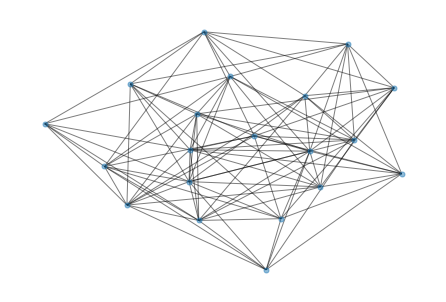

In [3]:
g1 = WattsStrogatz(20, 10, 0.5)
nx.draw(g1, alpha=.5, node_size=25)
nx.write_pajek(g1, "nets/WS_20_10_05.net")

In [4]:
# Networks generation
graphs = []
N = 30
K = 6
p_list = [0, 0.03, 0.1]
for p in p_list:
    print("N K p:", N, K, p)
    g = WattsStrogatz(N, K, p)
    #nx.save_pajek(g, f"nets/WS_N{N}_K{K}_p{p}.net")
    graphs.append(g)

N K p: 30 6 0
N K p: 30 6 0.03
N K p: 30 6 0.1


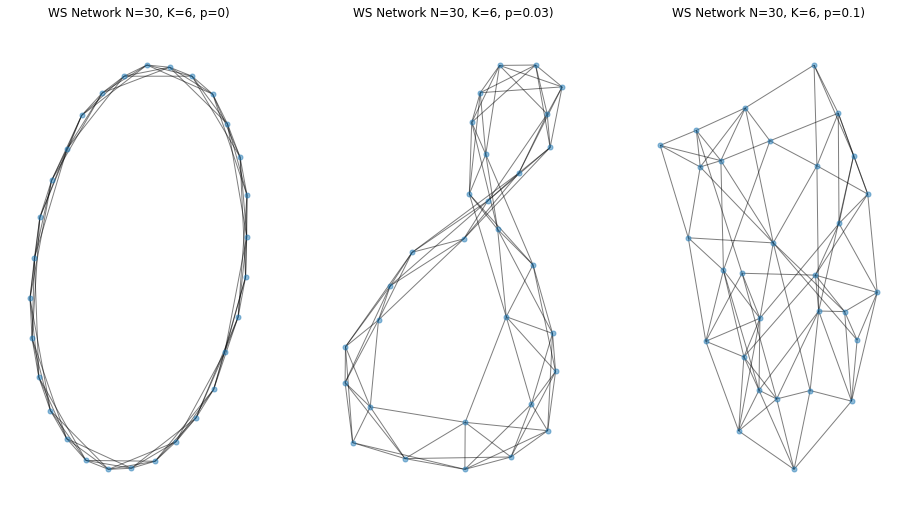

In [5]:
fig, axs = plt.subplots(1, len(p_list), figsize=(16, 9))
for i, g in enumerate(graphs):
    #plt.subplot(1, 3, i+1)
    axs[i].title.set_text(f"WS Network N={N}, K={K}, p={p_list[i]})")
    nx.draw(g, alpha=0.5, node_size=25, ax=axs[i])
    nx.write_pajek(graphs[i], f"nets/WS_N{N}_K{K}_p{p_list[i]}.net")

fig.savefig(f"images/WS_N{N}_K{K}_p{p_list[i]}.png")

As expected, when the rewiring probability is 0, the network keeps in its initial state: a regular ring lattice. However, even a small rewiring probability can strongly impact the structure of the network.

# Comparing the influence of the rewiring probability on clustering and avg. path coeff

In [6]:
p_list = np.logspace(-4, 0, 500)
graphs = [WattsStrogatz(50, 6, p) for p in p_list]

ref_graph = WattsStrogatz(50, 6, 0)
c0, l0 = nx.average_clustering(ref_graph), nx.average_shortest_path_length(ref_graph)
print(c0, l0)

c_list = [nx.average_clustering(g) for g in graphs]
l_list = [nx.average_shortest_path_length(g) for g in graphs]

0.6000000000000005 4.591836734693878


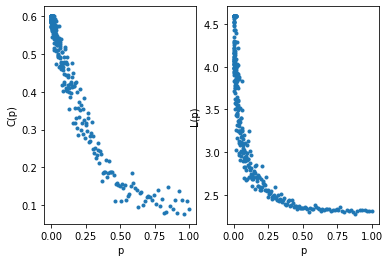

In [7]:
plt.subplot(1, 2, 1)
plt.plot(p_list, c_list, linewidth=0, marker='.')
plt.ylabel("C(p)")
plt.xlabel("p")

plt.subplot(1, 2, 2)
plt.plot(p_list, l_list, linewidth=0, marker='.')
plt.ylabel("L(p)")
plt.xlabel("p")

plt.savefig("WS_C_P_plot.png")

In [8]:
norm_c_list = [c/c0 for c in c_list]
norm_l_list = [l/l0 for l in l_list]

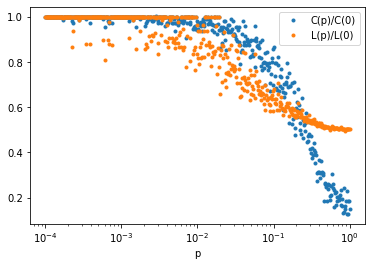

In [9]:
plt.plot(p_list, norm_c_list, linewidth=0, marker='.')
plt.plot(p_list, norm_l_list, linewidth=0, marker='.')
plt.legend(["C(p)/C(0)", "L(p)/L(0)"])
plt.xscale('log')
plt.xlabel("p")
plt.savefig("WS_log_C_P_plot.png")

In [10]:
print(l_list[-1])

2.3085714285714287


We can see that:
* The normalized average shortest path length ($L(p)/L(0)$) seems to converge toward 0.5, meaning that the higher the rewiring probability is, the more likely we are increasing by a factor of two the average shortest path length between two nodes.
* The clustering coefficient is decreasing when the rewiring probability is higher but don't seem to converge. The only conclusion we can draw here is that the rewiring process is highly removing clusters, compared to a network without rewiring.

## Big network analysis

In [40]:
ws_10k_p0 = WattsStrogatz(100, 6, 0)
ws_10k_p02 = WattsStrogatz(1e4, 6, 0.2)
ws_10k_p05 = WattsStrogatz(1e4, 6, 0.5)

Plotting theoretical degree distribution

In [34]:
import math
def ws_dd(k, K, p):
    total = 0
    K2 = int(K/2)
    for n in range(min(k-K2, K2)):
        elem = math.comb(K2, n) * (1-p)**n * p**(K2-n)
        elem *= np.around((p*K2)**(k-K2-n)/math.factorial(k-K2-n), 5)
        elem *= math.exp(-p*K2)
        
        total += elem
    
    return total

In [ ]:
k_list = sorted([val for key,val in ws_10k_p001.degree()])
p_list = [ws_dd(k, 6, 0.001) for k in k_list]
print(len(k_list), len(p_list))
print(k_list[:10], p_list[:10])

In [31]:
# Auxiliary function to create logaritmically spaced bins (for log-log histogram) by specifying the number of bins
def create_log_bins(degrees, num = 20):
    bins = np.logspace(np.log10(np.min(degrees)), np.log10(np.max(degrees)), num)
    bins = np.array(bins)
    return bins

# PDF histogram in linear scale
def plot_linear_PDF(G, name='', nbins = 15):
    degrees = [G.degree(n) for n in G.nodes()]
    #plt.figure(figsize=(12,8))
    plt.title('PDF in linear scale', fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.hist(degrees, bins=nbins, density = True, cumulative = False)
    plt.tight_layout()
    plt.style.use('ggplot')
    
# PDF histogram in Log-Log scale
def plot_loglog_PDF(G, name="", nbins=20):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # creating logaritmically spaced bins
    bins = create_log_bins(degrees, num = nbins)
    
    #plt.figure(figsize=(12,8))
    plt.title('PDF in log-log scale',  fontsize=15)
    plt.xlabel('Degree', fontsize=13)
    plt.ylabel('PDF', fontsize=13)
    plt.yscale('log')
    plt.xscale('log')
    plt.hist(degrees, bins=bins, density = True, cumulative = False)
    plt.tight_layout()
    #plt.style.use('ggplot')

In [37]:
# Plotting dirac model. 
# Warning : too low probability may result in Python numerical precision issues
def plot_WS_model(G, K, p):
    k_list = sorted([val for key,val in G.degree()])
    p_list = [ws_dd(k, K, p) for k in k_list]
    plt.plot(k_list, p_list)

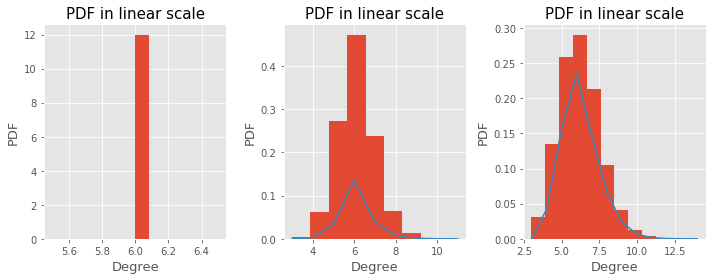

In [62]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.subplot(1, 3, 1)
plot_linear_PDF(ws_10k_p0, nbins=12)
plot_WS_model(ws_10k_p0, 6, 0)

plt.subplot(1, 3, 2)
plot_linear_PDF(ws_10k_p02, nbins=9)
plot_WS_model(ws_10k_p02, 6, 0.2)

plt.subplot(1, 3, 3)
plot_linear_PDF(ws_10k_p05, nbins=12)
plot_WS_model(ws_10k_p05, 6, 0.5)

plt.savefig("WS_p0-02-05_PDF.png")

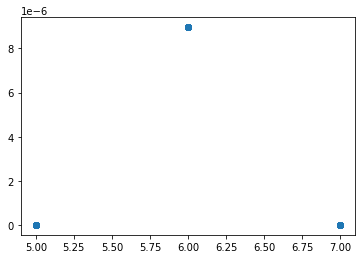

In [14]:
plt.plot(k_list, p_list, linewidth=0, marker="o")